## Sentinel-1 image pair velocity flux gate discharge calculations


In [2]:
# Import modules
import warnings
import xarray as xr
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import dask
import pandas as pd
import glob
from datetime import datetime
import re
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
import subprocess
import sys
import math
import shapely

import geopandas
import rioxarray as rio
from rioxarray.merge import merge_datasets
from shapely.geometry import mapping
from rasterio.enums import Resampling

## Define data directories

In [3]:
internal_data_dir = 'C:/Users/s1834371/Documents/GrIS_late-season-melt-event' #internal data dir within the github repo
data_dir = 'C:/Users/s1834371/Documents/DATA_FOR_GRIS-LATE-SEASON-MELT'#'R:/DATA_FOR_GRIS-LATE-SEASON-MELT'# External data (e.g. bedmachine)

### Define all functions used for processing

In [42]:
def print_raster(raster): # displays useful information on rasters
    print(
        f"shape: {raster.rio.shape}\n"
        f"resolution: {raster.rio.resolution()}\n"
        f"bounds: {raster.rio.bounds()}\n"
        f"CRS: {raster.rio.crs}\n"
    )

def retrieve_timestamp(tiff_list): # retrieves timestamp from .tif filename and then adds it as a dimension
    time = []
    for f, n in zip(tiff_list, range(len(tiff_list))):
        match = re.search(r"_((\d+)_(\d+))_250m", f) # search through filename and retreive pair start/end time
        pair_start = pd.to_datetime(match.group(2), format='%Y%m%d')
        pair_end = pd.to_datetime(match.group(3), format='%Y%m%d')
        time_between = pair_start + (pair_end - pair_start)/2 # calculate time between
        time.append(time_between)
    return time


def ROI_select(DATA, ROI_dir, invert=None): # clips raster to given shapefile area, option to invert or not
        #print('Clipping DATA to ROI')
        shapefile_dir = ROI_dir
        glacier_shape = geopandas.read_file(shapefile_dir)
        DATA.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
        DATA.rio.write_crs("epsg:3413", inplace=True)
        DATA = DATA.rio.clip(glacier_shape.geometry.apply(mapping), glacier_shape.crs, drop=True, all_touched=True, invert=invert)
        return DATA

def common_grid(data, name, raster=None): # reprojects rio datasets to a common grid system
    if raster == True:
        data = data.to_dataset('band') # convert to dataset
        data = data.rename({1: name}) # rename band to speed
    data.rio.write_crs("epsg:3413", inplace=True) # set CRS, north polar stereographic
    commongrid = data.rio.reproject_match(geotiffs_S_avg, resampling=Resampling.nearest) # resample to velocity grid
    commongrid = commongrid.assign_coords({"x": geotiffs_S_avg.x, "y": geotiffs_S_avg.y,}) # set to velocity grid, due to tiny differences
    commongrid = ROI_select(commongrid, internal_data_dir + '\data\discharge\GIMP_landmask_nps.shp', invert=True) # clip to ice
    
    return commongrid



### Flux-gate discharge function

In [5]:
tiff_list_U = glob.glob(data_dir + '/AS_S1_velocities/U/U_*timefiltered.tif') # U tifs
tiff_list_V = glob.glob(data_dir + '/AS_S1_velocities/V/V_*timefiltered.tif') # V tifs
gimp_dem_list = glob.glob(data_dir + '/gimpdem*.tif') # surface elevation DEM

### Load in Sentinel-1 ice velocities

In [36]:
# #Create variable used for time axis
time_var = xr.Variable('time', retrieve_timestamp(tiff_list_U)) # Assuming U AND V have the same timestamps

#Average_velocity FOR COMMON GRID
geotiffs_S_avg = xr.open_rasterio(data_dir + '/AS_S1_velocities/S/other/S_avg_20160103_20230529_250m_timefiltered.tif', chunks='auto')
geotiffs_S_avg = geotiffs_S_avg.to_dataset('band') # convert to dataset
geotiffs_S_avg = geotiffs_S_avg.rename({1: 'S'}) # rename band to speed

# # U component of velocity
geotiffs_U = xr.concat([xr.open_rasterio(i, chunks='auto') for i in tiff_list_U], dim=time_var)
geotiffs_U = geotiffs_U.to_dataset('band') # convert to dataset
geotiffs_U = geotiffs_U.rename({1: 'U'}) # rename band to speed

# # V component of velocity
geotiffs_V = xr.concat([xr.open_rasterio(i, chunks='auto') for i in tiff_list_V], dim=time_var)
geotiffs_V = geotiffs_V.to_dataset('band') # convert to dataset
geotiffs_V = geotiffs_V.rename({1: 'V'}) # rename band to speed

c:\Users\s1834371\Miniconda3\envs\JIF_main\lib\site-packages\xarray\core\concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [7]:
# geotiffs_V = geotiffs_V.sortby('time')
# geotiffs_U = geotiffs_U.sortby('time')


In [8]:
print(geotiffs_U.time)

<xarray.DataArray 'time' (time: 989)>
array(['2016-01-09T00:00:00.000000000', '2016-01-16T00:00:00.000000000',
       '2016-01-18T00:00:00.000000000', ..., '2023-05-15T00:00:00.000000000',
       '2023-05-18T00:00:00.000000000', '2023-05-23T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2016-01-09 2016-01-16 ... 2023-05-23


### Load in BedMachine and GIMP DEM

In [43]:
# Load in bed topography data and error
# BedMachineV5 = xr.open_rasterio(data_dir + '/BedMachineGreenland-v5_bed.tif')
# BedMachineV5_commongrid = common_grid(BedMachineV5, 'bed')
# BedMachineV5_commongrid_error = common_grid(BedMachineV5_error, 'bed_error')

# BedMachineV5 = xr.open_dataset(data_dir + '/BedMachineGreenland-v5.nc', engine='netcdf4')
# BedMachineV5['x'] = BedMachineV5['x'].astype('float64')
# BedMachineV5['y'] = BedMachineV5['y'].astype('float64')

# BedMachineV5_commongrid = common_grid(BedMachineV5['bed'], 'bed', raster=False)

# BedMachineV5_error = common_grid(BedMachineV5['errbed'], 'errbed', raster=False)
# BedMachineV5_thickness = common_grid(BedMachineV5['thickness'], 'thickness', raster=False)

# # Load in surface elevation data
# gimp_dem = xr.open_rasterio(data_dir + '/gimpdem_merged_SW.tif') #2009 to 2015
# gimp_dem_commongrid = common_grid(gimp_dem, 'elev', raster=True)

# gimp_dem_maxdate = xr.open_rasterio(data_dir + '/gimpdem_merged_SW_maxdate.tif') 
# gimp_dem_maxdate_commongrid = common_grid(gimp_dem_maxdate, 'date', raster=True)

# gimp_dem_mindate = xr.open_rasterio(data_dir + '/gimpdem_merged_SW_mindate.tif') 
# gimp_dem_mindate_commongrid = common_grid(gimp_dem_mindate, 'date', raster=True)

cryosat2 = xr.open_rasterio(data_dir + '/elevation_change_dataset_GrIS/Cryosat2_EC.tif')
cryosat2.rio.write_nodata(-3.40282e+38, inplace=True) # set nodata value
cryosat2_commongrid = common_grid(cryosat2, 'EC', raster=True) # 2010 TO 2018

ICEsat2 = xr.open_rasterio(data_dir + '/elevation_change_dataset_GrIS/ICEsat2_EC.tif')
ICEsat2.rio.write_nodata(-3.40282e+38, inplace=True) # set nodata value
ICEsat2_commongrid = common_grid(ICEsat2, 'EC', raster=True) # 2018 TO 2020

c:\Users\s1834371\Miniconda3\envs\JIF_main\lib\site-packages\rioxarray\raster_writer.py:132: UserWarning: The nodata value (-3.40282e+38) has been automatically changed to (-3.402820018375656e+38) to match the dtype of the data.
  warnings.warn(
c:\Users\s1834371\Miniconda3\envs\JIF_main\lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
c:\Users\s1834371\Miniconda3\envs\JIF_main\lib\site-packages\rioxarray\raster_writer.py:132: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
c:\Users\s1834371\Miniconda3\envs\JIF_main\lib\site-packages\rioxarray\raster_writer.py:132: UserWarning: The nodata value (-3.40282e+38) has been automatica

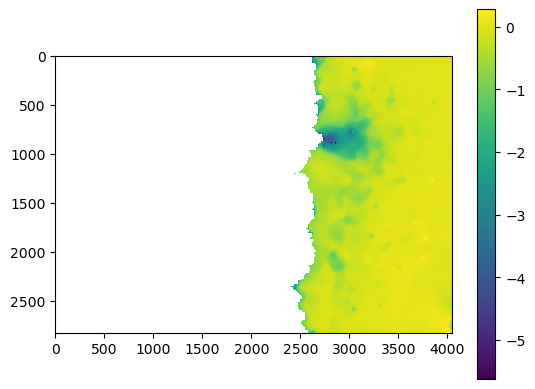

In [44]:
cryosat2_commongrid_2 = cryosat2_commongrid.where(cryosat2_commongrid['EC']<10000, np.nan)
cryosat2_commongrid_3 = cryosat2_commongrid_2.where(cryosat2_commongrid_2['EC']>-10000, np.nan)
cryosat2_commongrid_3.to_netcdf(data_dir + '/elevation_change_dataset_GrIS/Cryosat2_EC.nc')

plt.imshow(cryosat2_commongrid_3['EC'])
plt.colorbar()
plt.show()

In [10]:
geotiffs_U.rio.write_crs("epsg:3413", inplace=True) # set CRS, north polar stereographic
geotiffs_V.rio.write_crs("epsg:3413", inplace=True) # set CRS, north polar stereographic

<xarray.Dataset>
Dimensions:      (time: 989, y: 2826, x: 4048)
Coordinates:
  * y            (y) float64 -2.062e+06 -2.062e+06 ... -2.768e+06 -2.768e+06
  * x            (x) float64 -8.61e+05 -8.607e+05 ... 1.503e+05 1.505e+05
  * time         (time) datetime64[ns] 2016-01-09 2016-01-16 ... 2023-05-23
    spatial_ref  int32 0
Data variables:
    V            (time, y, x) float32 dask.array<chunksize=(1, 2826, 4048), meta=np.ndarray>
Attributes:
    transform:         (249.9444154703831, 0.0, -861104.9969120553, 0.0, -249...
    res:               (249.9444154703831, 249.94690892225623)
    is_tiled:          1
    nodatavals:        (nan,)
    scales:            (1.0,)
    offsets:           (0.0,)
    AREA_OR_POINT:     Area
    TIFFTAG_SOFTWARE:  MATLAB 9.12, Mapping Toolbox 5.3

### Calculating ice thickness using BedMachine V5 bed topography and the GIMP DEM adjusted using surface elevation change rates from Yang et al., 2022

In [11]:
date = pd.to_datetime('2020') - pd.to_datetime('2010') # calculate time between
print(int(date/np.timedelta64(365, 'D')))


10


In [45]:
##### Setting all fill/NaN values to zero elevation change rate #####
cryosat2_commongrid_2 = cryosat2_commongrid.where(cryosat2_commongrid['EC']<10000, 0)
cryosat2_commongrid_3 = cryosat2_commongrid_2.where(cryosat2_commongrid_2['EC']>-10000, 0)
ICEsat2_commongrid_2 = ICEsat2_commongrid.where(ICEsat2_commongrid['EC']<10000, 0)
ICEsat2_commongrid_3 = ICEsat2_commongrid_2.where(ICEsat2_commongrid_2['EC']>-10000, 0)

ICEsat2_commongrid_3.to_netcdf(data_dir + '/elevation_change_dataset_GrIS/ICEsat2_EC_3.nc')

year_list = pd.date_range(start='2016', end='2024', freq='1AS') # list of years in velocithy dataset to act as timestamps

initial_elev = gimp_dem_commongrid['elev'].values
for i, year in enumerate(year_list):
    print(year)

    if year <= pd.to_datetime('2017'): # USE GIMPDEM + CRYOSAT2
        mult_factor = int((pd.to_datetime('2020') - year)/np.timedelta64(365, 'D')) # calculate how many times to apply cryosat2 elevation change (m/year)
        surf_elev = initial_elev + (-1 * cryosat2_commongrid_3['EC'].values * mult_factor) # x -1 to reverse cryosat2 elevation change

        surf_elev_dataset = xr.Dataset(data_vars=dict(surf_elev=(["y", "x"], surf_elev)), 
                                coords=dict(x=(["x"], gimp_dem_commongrid.x.values),y=(["y"], gimp_dem_commongrid.y.values)))

        surf_elev_dataset = surf_elev_dataset.assign_coords(time = year)
        surf_elev_dataset = surf_elev_dataset.expand_dims(dim="time")

        if i == 0:
            surf_elev_dataset_complete = surf_elev_dataset
        else:
            surf_elev_dataset_complete = xr.concat([surf_elev_dataset_complete, surf_elev_dataset], dim='time')
        
    elif (pd.to_datetime('2018') <= year < pd.to_datetime('2020')): # USE GIMPDEM + ICEsat2:
        mult_factor = int((pd.to_datetime('2020') - year)/np.timedelta64(365, 'D')) # calculate how many times to apply cryosat2 elevation change (m/year)
        surf_elev = initial_elev + (-1 * ICEsat2_commongrid_3['EC'].values  * mult_factor) # x -1 to reverse cryosat2 elevation change
        
        surf_elev_dataset = xr.Dataset(data_vars=dict(surf_elev=(["y", "x"], surf_elev)), 
                        coords=dict(x=(["x"], gimp_dem_commongrid.x.values),y=(["y"], gimp_dem_commongrid.y.values)))

        surf_elev_dataset = surf_elev_dataset.assign_coords(time = year)
        surf_elev_dataset = surf_elev_dataset.expand_dims(dim="time")

        surf_elev_dataset_complete = xr.concat([surf_elev_dataset_complete, surf_elev_dataset], dim='time')
    
    elif year==pd.to_datetime('2020'): # USE GIMP DEM
        surf_elev = initial_elev
   
        surf_elev_dataset = xr.Dataset(data_vars=dict(surf_elev=(["y", "x"], surf_elev)), 
                        coords=dict(x=(["x"], gimp_dem_commongrid.x.values),y=(["y"], gimp_dem_commongrid.y.values)))

        surf_elev_dataset = surf_elev_dataset.assign_coords(time = year)
        surf_elev_dataset = surf_elev_dataset.expand_dims(dim="time")

        surf_elev_dataset_complete = xr.concat([surf_elev_dataset_complete, surf_elev_dataset], dim='time')
    
    elif year > pd.to_datetime('2020'): # USE GIMPDEM + ICEsat2
        mult_factor = int((year - pd.to_datetime('2020'))/np.timedelta64(365, 'D')) # calculate how many times to apply cryosat2 elevation change (m/year)
        surf_elev = initial_elev + (ICEsat2_commongrid_3['EC'].values  * mult_factor) 
        
        surf_elev_dataset = xr.Dataset(data_vars=dict(surf_elev=(["y", "x"], surf_elev)), 
                        coords=dict(x=(["x"], gimp_dem_commongrid.x.values),y=(["y"], gimp_dem_commongrid.y.values)))

        surf_elev_dataset = surf_elev_dataset.assign_coords(time = year)
        surf_elev_dataset = surf_elev_dataset.expand_dims(dim="time")

        surf_elev_dataset_complete = xr.concat([surf_elev_dataset_complete, surf_elev_dataset], dim='time')

for i, year in enumerate(year_list):
    if i ==0:
        ice_thickess = surf_elev_dataset_complete['surf_elev'].loc[dict(time=year)].values - BedMachineV5_commongrid.values 

        ice_thickness_dataset_complete = xr.Dataset(data_vars=dict(ice_thickness=(["y", "x"], ice_thickess)), 
                        coords=dict(x=(["x"], gimp_dem_commongrid.x.values),y=(["y"], gimp_dem_commongrid.y.values)))

        ice_thickness_dataset_complete = ice_thickness_dataset_complete.assign_coords(time = year)
        ice_thickness_dataset_complete = ice_thickness_dataset_complete.expand_dims(dim="time")
    else:
        ice_thickess = surf_elev_dataset_complete['surf_elev'].loc[dict(time=year)].values - BedMachineV5_commongrid.values

        ice_thickness_dataset = xr.Dataset(data_vars=dict(ice_thickness=(["y", "x"], ice_thickess)), 
                        coords=dict(x=(["x"], gimp_dem_commongrid.x.values),y=(["y"], gimp_dem_commongrid.y.values)))

        ice_thickness_dataset = ice_thickness_dataset.assign_coords(time = year)
        ice_thickness_dataset = ice_thickness_dataset.expand_dims(dim="time")

        ice_thickness_dataset_complete = xr.concat([ice_thickness_dataset_complete, ice_thickness_dataset], dim='time')




2016-01-01 00:00:00
2017-01-01 00:00:00
2018-01-01 00:00:00
2019-01-01 00:00:00


c:\Users\s1834371\Miniconda3\envs\JIF_main\lib\site-packages\xarray\core\concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


2020-01-01 00:00:00
2021-01-01 00:00:00
2022-01-01 00:00:00
2023-01-01 00:00:00
2024-01-01 00:00:00


In [13]:
year_list

DatetimeIndex(['2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01',
               '2020-01-01', '2021-01-01', '2022-01-01', '2023-01-01',
               '2024-01-01'],
              dtype='datetime64[ns]', freq='AS-JAN')

In [14]:
surf_elev_dataset_complete

<xarray.Dataset>
Dimensions:    (time: 9, y: 2826, x: 4048)
Coordinates:
  * x          (x) float64 -8.61e+05 -8.607e+05 ... 1.503e+05 1.505e+05
  * y          (y) float64 -2.062e+06 -2.062e+06 ... -2.768e+06 -2.768e+06
  * time       (time) datetime64[ns] 2016-01-01 2017-01-01 ... 2024-01-01
Data variables:
    surf_elev  (time, y, x) float32 3.403e+38 3.403e+38 ... 3.403e+38 3.403e+38

In [15]:
ICEsat2_commongrid_3

<xarray.Dataset>
Dimensions:      (y: 2826, x: 4048)
Coordinates:
  * x            (x) float64 -8.61e+05 -8.607e+05 ... 1.503e+05 1.505e+05
  * y            (y) float64 -2.062e+06 -2.062e+06 ... -2.768e+06 -2.768e+06
    spatial_ref  int32 0
Data variables:
    EC           (y, x) float32 0.0 0.0 0.0 0.0 ... -0.09217 -0.09328 -0.09439
Attributes:
    transform:      (5000.0, 0.0, -610890.0811, 0.0, -5000.0, -791889.3876999...
    res:            (5000.0, 5000.0)
    is_tiled:       1
    nodatavals:     (-3.4028234663852886e+38,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area

c:\Users\s1834371\Miniconda3\envs\JIF_main\lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


<bound method Mapping.values of <xarray.Dataset>
Dimensions:      ()
Coordinates:
    spatial_ref  int32 0
Data variables:
    EC           float32 0.0>


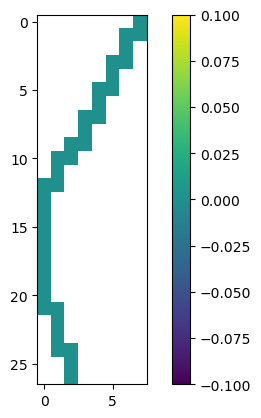

In [46]:
gate = 'IS_gate'
gate_shapefile = glob.glob(internal_data_dir + '/data/discharge/flux_gates/%s.shp' % gate)

test = ROI_select(ICEsat2_commongrid_3, gate_shapefile[0], invert=False)
test = test.where(test['EC']<10000000000000, np.nan)
#test = test.where(test['elev']>0, np.nan)
print(test.mean().values)

plt.imshow(test['EC'])
plt.colorbar()
plt.show()

# for i in test.time:
#     print(test['EC'].sel(time=i).mean().values)
#     # plt.imshow(test.sel(time=i)['surf_elev'])
#     # plt.show()

In [47]:
gate = 'IS_gate'
gate_shapefile = glob.glob(internal_data_dir + '/data/discharge/flux_gates/%s.shp' % gate)

test = ROI_select(surf_elev_dataset_complete, gate_shapefile[0], invert=False)
test = test.where(test['surf_elev']<10000000000000, np.nan)
#test = test.where(test['elev']>0, np.nan)

for i in test.time:
    print(test['surf_elev'].sel(time=i).mean().values)
    # plt.imshow(test.sel(time=i)['surf_elev'])
    # plt.show()

c:\Users\s1834371\Miniconda3\envs\JIF_main\lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


571.7951
571.0155
568.6769
568.6769
568.6769
568.6769
568.6769
568.6769
568.6769


In [18]:
gate = 'UNNAMED_SOUTH_gate'
gate_shapefile = glob.glob(internal_data_dir + '/data/discharge/flux_gates/%s.shp' % gate)

test = ROI_select(gimp_dem_maxdate_commongrid, gate_shapefile[0], invert=False)
test = test.where(test['elev']<10000000000000, np.nan)
#test = test.where(test['elev']>0, np.nan)

from datetime import date, timedelta

# days = 9465                 # This may work for floats in general, but using integers
#                             #   is more precise (e.g. days = int(9465.0))

# start = date(1990,1,1)      # This is the "days since" part

# delta = timedelta(days)     # Create a time delta object from the number of days

# offset = start + delta      # Add the specified number of days to 1990

# print(offset)               # >>>  2015-12-01
# print(type(offset))  

offset = int(test['elev'].mean().values)
start = date(2000,1,1)
date = start + timedelta(offset)
print(date)

# for i in test.time:
#     print(test['surf_elev'].sel(time=i).mean().values)
#     # plt.imshow(test.sel(time=i)['surf_elev'])
#     # plt.show()

c:\Users\s1834371\Miniconda3\envs\JIF_main\lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


KeyError: 'elev'

In [48]:
BedMachineV5_thickness = xr.Dataset(data_vars=dict(ice_thickness=(["y", "x"], BedMachineV5_thickness.values)), 
                        coords=dict(x=(["x"], gimp_dem_commongrid.x.values),y=(["y"], gimp_dem_commongrid.y.values)))


BedMachineV5_thickness = BedMachineV5_thickness.where(BedMachineV5_thickness < 10000, 0)
BedMachineV5_thickness['ice_thickness'].rio.write_crs("epsg:3413", inplace=True) # set CRS, north polar stereographic
BedMachineV5_thickness['ice_thickness'].rio.write_nodata(0)
#BedMachineV5_thickness_2.plot()

<xarray.DataArray 'ice_thickness' (y: 2826, x: 4048)>
array([[-3.4028200e+38, -3.4028200e+38, -3.4028200e+38, ...,
         3.0698096e+03,  3.0694944e+03,  3.0692168e+03],
       [-3.4028200e+38, -3.4028200e+38, -3.4028200e+38, ...,
         3.0696157e+03,  3.0692935e+03,  3.0690178e+03],
       [-3.4028200e+38, -3.4028200e+38, -3.4028200e+38, ...,
         3.0693735e+03,  3.0690522e+03,  3.0687830e+03],
       ...,
       [-3.4028200e+38, -3.4028200e+38, -3.4028200e+38, ...,
         9.3789636e+02,  9.5280573e+02,  9.6869049e+02],
       [-3.4028200e+38, -3.4028200e+38, -3.4028200e+38, ...,
         8.9816974e+02,  9.0932739e+02,  9.2118927e+02],
       [-3.4028200e+38, -3.4028200e+38, -3.4028200e+38, ...,
         8.4420575e+02,  8.5197485e+02,  8.6016888e+02]], dtype=float32)
Coordinates:
  * x        (x) float64 -8.61e+05 -8.607e+05 -8.605e+05 ... 1.503e+05 1.505e+05
  * y        (y) float64 -2.062e+06 -2.062e+06 ... -2.768e+06 -2.768e+06
Attributes:
    _FillValue:  0.0

In [ ]:
BedMachineV5_thickness

<xarray.Dataset>
Dimensions:        (y: 2826, x: 4048)
Coordinates:
  * x              (x) float64 -8.61e+05 -8.607e+05 ... 1.503e+05 1.505e+05
  * y              (y) float64 -2.062e+06 -2.062e+06 ... -2.768e+06 -2.768e+06
    spatial_ref    int32 0
Data variables:
    ice_thickness  (y, x) float32 0.0 0.0 0.0 0.0 ... 838.9 844.2 852.0 860.2

In [49]:
################# LOAD IN METADATA FOR STANDARD DEVIATION #########################
col_names = ['start_year', 'start_month', 'start_day', 'end_year', 'end_month', 'end_day', 'min_off-ice_vel', 'max_off-ice_vel', 'mean_off-ice_vel', 'median_off-ice_vel', 'std_off-ice_vel']

u_std_file = pd.read_csv(data_dir + '/AS_S1_velocities/U/U_metadata_250m_20160103_20230529.txt', header=None, delimiter=',', usecols=[0,1,2,6,7,8,12,13,14,15,16], names=col_names) #skips columns with 0
u_std_file['start_date'] = pd.to_datetime(dict(year=u_std_file.start_year, month=u_std_file.start_month, day=u_std_file.start_day))
u_std_file['end_date'] = pd.to_datetime(dict(year=u_std_file.end_year, month=u_std_file.end_month, day=u_std_file.end_day))
u_std_file = u_std_file.drop(columns=['start_year', 'start_month', 'start_day', 'end_year', 'end_month', 'end_day'])
u_std_file['time_between'] = u_std_file['start_date'] + (u_std_file['end_date'] - u_std_file['start_date'])/2 # calculate time between
u_std_file.index = u_std_file['time_between']

v_std_file = pd.read_csv(data_dir + '/AS_S1_velocities/V/V_metadata_250m_20160103_20230529.txt', header=None, delimiter=',', usecols=[0,1,2,6,7,8,12,13,14,15,16], names=col_names) #skips columns with 0
v_std_file['start_date'] = pd.to_datetime(dict(year=v_std_file.start_year, month=v_std_file.start_month, day=v_std_file.start_day))
v_std_file['end_date'] = pd.to_datetime(dict(year=v_std_file.end_year, month=v_std_file.end_month, day=v_std_file.end_day))
v_std_file = v_std_file.drop(columns=['start_year', 'start_month', 'start_day', 'end_year', 'end_month', 'end_day'])
v_std_file['time_between'] = v_std_file['start_date'] + (v_std_file['end_date'] - v_std_file['start_date'])/2 # calculate time between
v_std_file.index = v_std_file['time_between']

u_std = u_std_file['std_off-ice_vel']
v_std = v_std_file['std_off-ice_vel']

In [50]:
def retrieve_office_std(flat_u, flat_v, u_std_t, v_std_t):
        mean_u = np.nanmean(flat_u)
        mean_v = np.nanmean(flat_v)
        mean_s = (mean_u**2 + mean_v**2)**0.5

        error = (u_std_t*(((mean_u**2)**0.5)/mean_s)) + (v_std_t*(((mean_v**2)**0.5)/mean_s))

        return error

In [51]:
ice_thickness_dataset_complete['ice_thickness'].rio.write_crs("epsg:3413", inplace=True) # set CRS, north polar stereographic
ice_thickness_dataset_complete['ice_thickness'].rio.write_nodata(0)

ice_thickness_dataset_complete = ice_thickness_dataset_complete.where(ice_thickness_dataset_complete < 10000, 0)


In [ ]:
def ROI_select(DATA, ROI_dir, invert=None):
        ''' Clips Xarray DataArray to a given shapefile'''
        shapefile_dir = ROI_dir 
        glacier_shape = geopandas.read_file(shapefile_dir)

        DATA.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
        DATA.rio.write_crs("epsg:3413", inplace=True)
        DATA = DATA.rio.clip(glacier_shape.geometry.apply(mapping), glacier_shape.crs, drop=True, all_touched=True, invert=invert)

        return DATA

def perp_vel_v2(U, V, azimuth_gate_angles):
    ''' calculates perpendicualr velocity to gate for a given pixel '''
    azimuth = azimuth_gate_angles
    magnitude_vel = math.sqrt(U**2 + V**2) # velocity magnitude
    b = math.degrees(math.atan2(U,V)) # bearing of u and v velocity in DEGREES

    ang_diff = math.radians(azimuth+90) - math.radians(b)  #azimuth of gate is 90 degrees away from velocity perpendicular to gate!

    v_perp = magnitude_vel * math.cos(math.radians(ang_diff))
    #print('Original velocity: %.2f, Perp velocity: %.2f \nb: %.2f, angle difference: %.2f' % (magnitude_vel, v_perp, b, ang_diff))
    return v_perp

def retrieve_gate_azimuth(gate_shapefile):
    ''' Given a shapefile of a gate, calculates the azimuth of each gate segment and the coords of the centre of the segment'''
    glacier_shape = geopandas.read_file(gate_shapefile)
    a = glacier_shape.iloc[0].geometry
    coords = [c for c in a.coords]
    segments = [shapely.geometry.LineString([a, b]) for a, b in zip(coords,coords[1:])]

    azimuth_list = [] # list of azimuth angles for each segment
    azimuth_coord_list = [] # list of coods of each centroid

    for seg in range(len(segments)): # loops through each segments along the gate
            p1 = segments[seg].coords[0] # point 1 of segments
            p2 = segments[seg].coords[1] # point 2 of segment
            midpoint = segments[seg].centroid # coordinates of the middle of the segment
            coord_mid = (midpoint.x, midpoint.y)

            angle =  (-math.degrees(math.atan2(p2[1]-p1[1], p2[0]-p1[0]))+90) # calculating the azimuth angle         
            azimuth_coord_list.append(coord_mid)
            azimuth_list.append(angle)

    return azimuth_list, azimuth_coord_list

def flatten_gate(var): # flattens xarray/rio dataset into 1d array, used in flux-gate discharge calculations
    flatten = var.values.flatten()
    flatten_no_nan = flatten[~np.isnan(flatten)] # gets rid of NaN values
        
    return flatten_no_nan

def flux_gate_discharge(U, V, ice_thickness, gate, internal_data_dir):
    ice_density = 917 # kg m-3
    w = 250 # width of velocity pixel
    velocity_depth_reduction = 1 # to reduce velocity with depth

    gate_shapefile = glob.glob(internal_data_dir + '/data/discharge/flux_gates/%s.shp' % gate)

    # clip variables to pre-defined gate ROI
    U_gate = ROI_select(U['U'], gate_shapefile[0], invert=False)
    V_gate = ROI_select(V['V'], gate_shapefile[0], invert=False)

    bedmachine_thickness_gate = ROI_select(BedMachineV5_thickness, gate_shapefile[0], invert=False)
    thickness_gate = ROI_select(ice_thickness_dataset_complete, gate_shapefile[0], invert=False)
    bed_error = ROI_select(BedMachineV5_error, gate_shapefile[0]) # bedmachine error

    time =  pd.to_datetime(U_gate['time'].values)
    azimuth_list, azimuth_coord_list = retrieve_gate_azimuth(gate_shapefile[0])

    U_gate_xy = U_gate[0] # get rid of time dimension
    U_gate_xy_stacked = U_gate_xy.stack(xy=['x','y']) # stacks x and y coords 
    U_gate_xy_stacked = U_gate_xy_stacked[U_gate_xy_stacked.notnull()] # gets rid of NaN values
    coord_tuples = U_gate_xy_stacked.xy.values

    #### Loop below finds coordinate in U and V closest to the middle of each gate segment, uses this to select azimuth angle
    closest_distance = float('inf')
    azimuth_gate_angles = []
    for x1,y1 in coord_tuples:
         for index, (x2, y2) in enumerate(azimuth_coord_list):
              distance = math.sqrt((x1-x2)**2 + (y1-y2)**2) #
              if distance < closest_distance:
                    index_closest = index
              azimuth_gate_angles.append(azimuth_list[index_closest])

    if not (time == pd.to_datetime(V_gate['time'].values)).all():
        print("U and V time do not match!") # Check if the U file and V file are the same timestep
        sys.exit()

    discharge_time_array = [] # defining arrays to append data too
    gate_discharge_array = []
    u_error_array = [] # upper error bound
    l_error_array = [] # lower error bound

    for t, time_val in zip(range(len(time)), time):
        flat_U = flatten_gate(U_gate.isel(time=t)) # flatten U and V componenets so we can perform calculations with them
        flat_V = flatten_gate(V_gate.isel(time=t))
        bed_error_t = bed_error.mean().values

        u_std_t = u_std[time_val.strftime('%Y-%m-%d')]
        v_std_t = v_std[time_val.strftime('%Y-%m-%d')]
        vel_error_t = retrieve_office_std(flat_U, flat_V, u_std_t, v_std_t)

        if not any(V == -9999 for V in flat_V) and not any(U == -9999 for U in flat_U): # and not any(U > 0 for U in flat_U) and np.isnan(flat_U).any()==False and np.isnan(flat_V).any()==False:     
            U_gate_t_df = U_gate.isel(time=t) # for retrieving time
            U_gate_t = flat_U
            V_gate_t = flat_V

            time_thickness = pd.to_datetime(U_gate_t_df['time'].values).strftime('%Y') # creating time coord for the time-varying thickness estimate
            thickness_gate_year = thickness_gate['ice_thickness'].loc[dict(time=pd.to_datetime(time_thickness))] # select ice thickness at specified timestep

            S = [perp_vel_v2(U,V,a) for U,V,a in zip(U_gate_t, V_gate_t, azimuth_gate_angles)] # calculate velocity perpendicular to gate using already defined function 

            #print(bedmachine_thickness_gate.values.flatten())
            #print(len(S), len(flatten_gate(thickness_gate_year)), len(flatten_gate(bedmachine_thickness_gate['ice_thickness'])))

            discharge = S * flatten_gate(thickness_gate_year) * w * ice_density * velocity_depth_reduction   #calculate density at each bin
            gate_discharge_sum = np.sum(discharge) / 1e12 # sum along gate and convert to Gt year-1

            dis_error_max = (S+vel_error_t) * flatten_gate((thickness_gate_year+bed_error_t)) * w * ice_density  # upper bound with error and k
            gate_error_max = np.sum(dis_error_max) / 1e12

            dis_error_min = 0.8*(S-vel_error_t) * flatten_gate((thickness_gate_year-bed_error_t)) * w * ice_density # lower band with error and k
            gate_error_min= np.sum(dis_error_min) / 1e12

            u_error = gate_error_max - gate_discharge_sum
            l_error = gate_discharge_sum - gate_error_min

            width_averaged_thickness = np.mean(flatten_gate(thickness_gate_year))
            width_averaged_thickness_bedmachine = np.mean(flatten_gate(bedmachine_thickness_gate['ice_thickness']))
            print('THICKNESSES:', width_averaged_thickness, width_averaged_thickness_bedmachine)

            time_t = pd.to_datetime(U_gate_t_df['time'].values)
            discharge_time_array.append(time_t)
            gate_discharge_array.append(gate_discharge_sum)
            u_error_array.append(u_error)
            l_error_array.append(l_error)
            print('Time:', time_t, ', Discharge:', gate_discharge_sum, 'Gt yr-1')
        else:
             print('SKIPPED', pd.to_datetime(U_gate.isel(time=t)['time'].values))
            
    df_array = np.array([discharge_time_array, gate_discharge_array, u_error_array, l_error_array, width_averaged_thickness, width_averaged_thickness_bedmachine])
    df_array = np.transpose(df_array)
    discharge_df = pd.DataFrame(df_array, columns = ['time', 'discharge', 'u_error', 'l_error', 'width_averaged_thickness', 'width_averaged_thickness_bedmachine'])
    discharge_df.to_csv(internal_data_dir + '/data/discharge/%s_ice_discharge_v2.csv' % gate)
    print('Created discharge rates for gate: %s' % gate)

In [ ]:
gate_list = ['IS_gate', 'RUSSELL_gate', 'NORTH_NUNATAK_gate', 'SOUTH_NUNATAK_gate', 'UNNAMED_SOUTH_gate']
for gate in gate_list:
    print('\n\n\n---------------------------------------------')
    print('Calculating flux gate for:', gate, '\n')
    flux_gate_discharge(geotiffs_U, geotiffs_V, ice_thickness_dataset_complete, gate, internal_data_dir)




---------------------------------------------
Calculating flux gate for: IS_gate 



c:\Users\s1834371\Miniconda3\envs\JIF_main\lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
c:\Users\s1834371\Miniconda3\envs\JIF_main\lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
c:\Users\s1834371\Miniconda3\envs\JIF_main\lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, conver

SKIPPED 2016-01-09 00:00:00
THICKNESSES: 320.25772 286.1676
Time: 2016-01-16 00:00:00 , Discharge: 0.21152788830255453 Gt yr-1
SKIPPED 2016-01-18 00:00:00
SKIPPED 2016-01-21 00:00:00
SKIPPED 2016-02-02 00:00:00
THICKNESSES: 320.25772 286.1676
Time: 2016-02-09 00:00:00 , Discharge: 0.18541240836502904 Gt yr-1
SKIPPED 2016-02-14 00:00:00
THICKNESSES: 320.25772 286.1676
Time: 2016-02-21 00:00:00 , Discharge: 0.1926510282606321 Gt yr-1
SKIPPED 2016-02-23 00:00:00
SKIPPED 2016-02-24 00:00:00
SKIPPED 2016-02-26 00:00:00
THICKNESSES: 320.25772 286.1676
Time: 2016-03-04 00:00:00 , Discharge: 0.17672968015101667 Gt yr-1
SKIPPED 2016-03-06 00:00:00
SKIPPED 2016-03-09 00:00:00
THICKNESSES: 320.25772 286.1676
Time: 2016-03-16 00:00:00 , Discharge: 0.17249286023260985 Gt yr-1
SKIPPED 2016-03-18 00:00:00
SKIPPED 2016-03-21 00:00:00
THICKNESSES: 320.25772 286.1676
Time: 2016-03-28 00:00:00 , Discharge: 0.185741213505517 Gt yr-1
SKIPPED 2016-03-30 00:00:00
SKIPPED 2016-04-02 00:00:00
THICKNESSES: 320.

KeyboardInterrupt: 